<a href="https://colab.research.google.com/github/ov29/Research_project/blob/main/train_attacker_surgical_leaked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-Layer Perceptron on Surgical dataset (MLP) with a specified number of hidden layers, activation functions, and regularization techniques**

Training a Multi-Layer Perceptron (MLP) model on the Surgical dataset. Specifying various parameters of the model, such as its depth, regularization, dropout. After training, the script generates predictions for each instance in the train/test datasets. Subsequently, it creates a new dataset where half of the records are members of the training set, and the other half are not. Each record in the new dataset contains the output predictions of the trained model and a label indicating whether the instance was a member (0) or not (1) in the original train or test datasets, respectively.

usage: colab_kernel_launcher.py [-h] [--layers LAYERS] [--optimizer OPTIMIZER]
                                [--l1_rate L1_RATE] [--l2_rate L2_RATE]
                                [--dropout DROPOUT] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-e39e9774-74c5-40a1-99a7-e8b685568904.json


Hyperparameters:  {'layers': 1, 'optimizer': 'adam', 'l1_rate': 0, 'l2_rate': 0, 'dropout': 0, 'epochs': 25, 'batch_size': 16}
Epoch 1/25
732/732 [==============================] - 4s 3ms/step - loss: 0.5872 - accuracy: 0.7351 - precision: 0.7351 - recall: 0.7351 - val_loss: 0.4600 - val_accuracy: 0.7909 - val_precision: 0.7909 - val_recall: 0.7909
Epoch 2/25
732/732 [==============================] - 2s 2ms/step - loss: 0.4393 - accuracy: 0.7940 - precision: 0.7940 - recall: 0.7940 - val_loss: 0.4322 - val_accuracy: 0.7964 - val_precision: 0.7964 - val_recall: 0.7964
Epoch 3/25
732/732 [==============================] - 2s 2ms/step - loss: 0.4269 - accuracy: 0.7965 - precision: 0.7965 - recall: 0.7965 - val_loss: 0.4272 - val_accuracy: 0.7964 - val_precision: 0.7964 - val_recall: 0.7964
Epoch 4/25
732/732 [==============================] - 2s 2ms/step - loss: 0.4226 - accuracy: 0.7980 - precision: 0.7980 - recall: 0.7980 - val_loss: 0.4257 - val_accuracy: 0.7957 - val_precision: 0.795

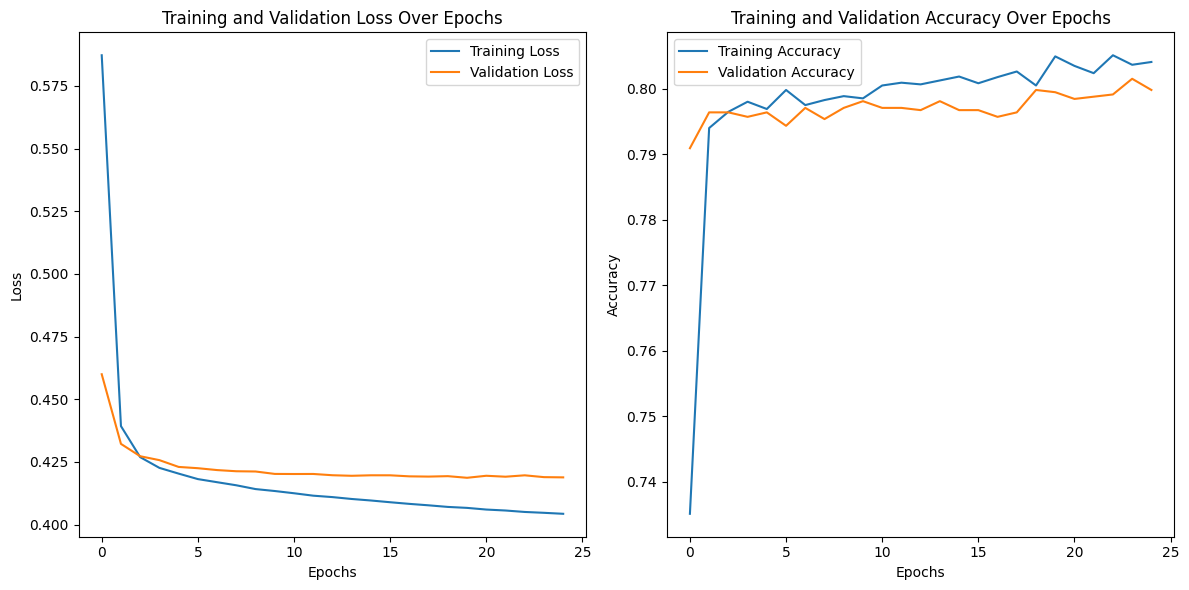

In [1]:
"""
This script trains an MLP on the Surgical dataset. The parameters of the model, such as its depth, regularization, dropout, etc.,
can be provided by the user. Finally, the predictions of the trained model on each train/test instance are acquired and
a new dataset, where half of the records are members in the training set and half of them are not, is created. Each
record in the new dataset contains the output predictions of the trained model and a label corresponding to whether the
instance that triggered those outputs was a member (0) or not (1) in the original train or test datasets, respectively.
"""
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import argparse
from keras import models
from keras import layers
from keras import regularizers
import json
import matplotlib.pyplot as plt

def directory_creator():
    path = "surgical/"
    if not os.path.exists("surgical"):
        os.makedirs(path)
        path = path + "exp0"
        os.makedirs(path)
    else:
        dirs = os.listdir(path)
        count_max = 0
        for dir in dirs:
            if not os.path.isdir(path + dir) or 'exp' not in dir:
                continue
            exp_no = dir.replace('exp', '')
            try:
                exp_no = int(exp_no)
            except:
                continue
            if exp_no > count_max:
                count_max = exp_no
        path = "surgical/exp" + str(count_max + 1)
        os.makedirs(path)
    return path

def main():
    results_path = directory_creator()

    # parse arguments
    opt = parse_opt()
    with open(results_path + '/info.txt', 'w') as file:
        file.write(json.dumps(opt) + "\n")
    print("Hyperparameters: ", opt)

    # load the data
    try:
        df = pd.read_csv("Surgical-deepnet.csv", index_col=False, skipinitialspace=True)
    except:
        print("Surgical-deepnet.csv dataset not found!")
        print("Download the dataset from https://www.kaggle.com/datasets/omnamahshivai/surgical-dataset-binary-classification?select=Surgical-deepnet.csv")
        print("Place the downloaded dataset in /surgical folder.")
        exit(0)

    # Preprocess dataset
    df = df.replace('?', np.nan)
    df.dropna(inplace=True)
    normalize_columns = ['bmi','Age','ahrq_ccs','ccsComplicationRate','ccsMort30Rate','complication_rsi','dow','gender','hour','month','moonphase','mortality_rsi','race']
    normalize(normalize_columns, df)

    x_data = df.drop('complication', axis=1)
    y_labels = df['complication']
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, shuffle=True)
    y_train = tf.one_hot(y_train, depth=2)
    y_test = tf.one_hot(y_test, depth=2)

    # create and train the target model
    model = models.Sequential()
    model.add(layers.InputLayer(X_train.shape[1:], name='input_layer'))
    for i in range(opt['layers']):
        model.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizers.l2(l=opt['l2_rate']) if opt['l1_rate'] == 0 else regularizers.l1(l=opt['l1_rate'])))
        model.add(layers.Dropout(opt['dropout'], noise_shape=None, seed=None))
    model.add(layers.Dense(2, activation="softmax", name='output_layer'))

    if opt['optimizer'] == 'adamw':
        optimizer = tf.keras.optimizers.experimental.AdamW()
    else:
        optimizer = opt['optimizer']

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy", "Precision", "Recall"]
    )

    results = model.fit(
        X_train, y_train,
        epochs=opt['epochs'],
        batch_size=opt['batch_size'],
        validation_data=(X_test, y_test)
    )

    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ... (unchanged)

def normalize(columns, df):
    scaler = preprocessing.StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])

def shuffle_data(results_path):
    with open(results_path+"/train.csv", 'r') as file:
        lines = file.readlines()

    random.shuffle(lines)

    with open(results_path+"/train.csv", 'w') as file:
        for line in lines:
            file.write(line)

    with open(results_path+"/test.csv", 'r') as file:
        lines = file.readlines()

    random.shuffle(lines)

    with open(results_path+"/test.csv", 'w') as file:
        for line in lines:
            file.write(line)

def create_train_test_subsets(pred_train, pred, results_path):
    with open(results_path+'/train.csv', 'w') as file:
        for line in pred_train[:2500]:
            for i in line:
                file.write(str(i) + ",")
            file.write('0\n')
        for line in pred[:2500]:
            for i in line:
                file.write(str(i) + ",")
            file.write('1\n')

    with open(results_path+'/test.csv', 'w') as file:
        for line in pred_train[2500:]:
            for i in line:
                file.write(str(i) + ",")
            file.write('0\n')
        for line in pred[2500:]:
            for i in line:
                file.write(str(i) + ",")
            file.write('1\n')

def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--layers', type=int, default=1, help='number of hidden layers for the MLP architecture')
    parser.add_argument('--optimizer', type=str, default='adam', help='optimizer options: sgd, adam, rmsprop, adamax, adadelta, adagrad, adamw')
    parser.add_argument('--l1_rate', type=float, default=0, help='l1 regularisation rate per layer')
    parser.add_argument('--l2_rate', type=float, default=0, help='l2 regularisation rate per layer')
    parser.add_argument('--dropout', type=float, default=0, help='dropout rate per layer')
    parser.add_argument('--epochs', type=int, default=25, help='no. of training epochs')
    parser.add_argument('--batch_size', type=int, default=16, help='batch size')

    try:
        opt = parser.parse_args()
    except:
        opt = {
            'layers': 1,
            'optimizer': 'adam',
            'l1_rate': 0,
            'l2_rate': 0,
            'dropout': 0,
            'epochs': 25,
            'batch_size': 16
        }

    return opt

# execute program
main()
